# Data Visualization Project
Student: Lucas Gabriel Mocellin Teixeira

## Introduction

The purpose of this project is to select a dataset that allows a network analysis through visualization techniques. 

The data selected is divided into two datasets (BKFRAB and BKRFAC). It concerns interactions among students living in a fraternity at a West Virginia college. All subjects had been residents in the fraternity from three months to three years. BKFRAB records the number of times a pair of subjects were seen in conversation by an "unobtrusive" observer (who walked through the public areas of the building every fifteen minutes, 21 hours a day, for five days). BKFRAC contains rankings made by the subjects of how frequently they interacted with other subjects in the observation week. These data can be found on the following website: http://vlado.fmf.uni-lj.si/pub/networks/data/ucinet/ucidata.htm#bkfrat

## Tasks

- Identify clusters/communities: By apllying commuity recognition algorithms and visualizing the social network, it is possible to identify patterns and dynamics of the interactions between students. This could be useful for identifying cliques or subgroups within the fraternity or understanding how information flows through the network.
- Identify the most socially connected students: using data visualization techniques such as network diagrams, it is possible to map out the social connections among the fraternity students. By analyzing the number of interactions between students and their frequency of conversation, the most socially connected students can be identified. This information can be useful in various ways, such as selecting leaders for group projects or identifying potential mentors.
- Analyse degree distribution: It would contribute to understanding the topology or structure of the social network among the fraternity students. Specifically, it would provide information about the distribution of the number of connections or interactions each student has with other students.
- Compare self-reported interactions to observed interactions: Comparing the rankings made by the subjects of how frequently they interacted with other subjects in the observation week to the actual number of times they were seen conversing can provide insights into how accurate people are in self-reporting their social interactions.

## Implementation

#### Import libraries

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

sns.set()
sns.set_style("white")

#### Read and prepare data

In [2]:
# read matrices (text files)

matrix_b = np.loadtxt('data/bkfratb.txt', dtype=int)
matrix_c = np.loadtxt('data/bkfratc.txt', dtype=int)

# create a graph object from the adjacency matrix
G_b = nx.Graph(matrix_b)

# get the edge weights as a list
edge_weights = [G_b[i][j]['weight']/10 for i, j in G_b.edges()]

# create a kamada kawai layout for node positioning
pos = nx.kamada_kawai_layout(G_b)

print("Number of edges: {0}\nNumber of nodes: {1}".format(G_b.number_of_edges(), G_b.number_of_nodes()))

Number of edges: 967
Number of nodes: 58


#### Static Visualizatons

##### Community Visualization
The purpose of this visualization is to understand the dynamics of the behavorial social network: clusters, density, influential individuals and frequency variations.

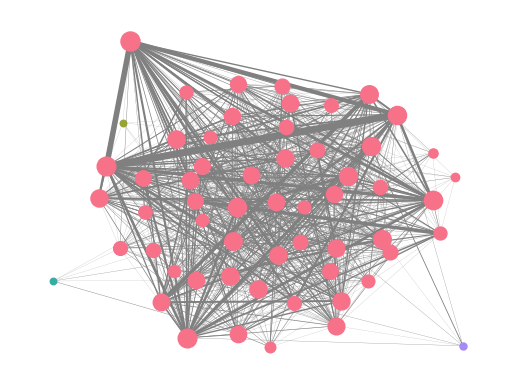

In [3]:
# apply Girvan Newman method for community identification
comp = nx.community.girvan_newman(G_b)
k = 4  # number of communities
for _ in range(k-1):
    comms = next(comp)
    
# define color list from Seaborn color palette
color_list =  sns.color_palette("husl", k)

# create a list of sizes based on vertex's normalized degree centrality
sizes = nx.degree_centrality(G_b)
sizes_sum = sum(sizes.values())
sizes_norm = {node: score / sizes_sum for node, score in sizes.items()}

# create graph with color coded communities
for comm, c in zip(comms, color_list):
    for node in comm:
        nx.draw_networkx_nodes(G_b, pos, nodelist=[node], node_color=[c], node_size=7000*sizes_norm[node])

nx.draw_networkx_edges(G_b, pos, width=edge_weights, edge_color="gray")    

plt.axis('off')
plt.show()

#### Degree Distribution
The purpose of plottig a degree distribution is to understand the topology or structure of the social network among the fraternity students. Specifically, it provides information about the distribution of the number of connections or interactions each student has with other students.

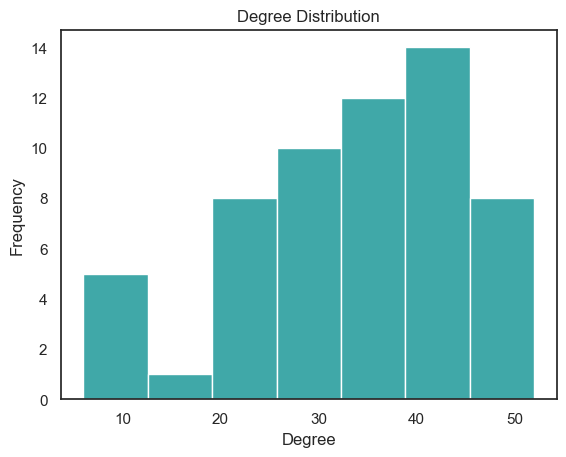

In [4]:
degrees = [degree for (node, degree) in G_b.degree()]

# plot a histogram of the degree distribution
sns.histplot(degrees, kde=False, color='darkcyan')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

### Interactive Visualization

In [5]:
import plotly.express as px
import jupyter_dash as jd
import dash
from dash import dcc, html  

# Convert adjacency matrices to dataframes
freq_df = pd.DataFrame(matrix_b)
rank_df = pd.DataFrame(matrix_c)

# Create JupyterDash app
app = jd.JupyterDash(__name__)

# Define app layout
app.layout = html.Div([
    # Dropdown for selecting node rank
    dcc.Dropdown(
        id='rank-dropdown',
        options=[{'label': str(i), 'value': i} for i in range(6)] +
                    [{'label': 'All ranks', 'value': 'all'}],
            value='all'
    ),
    # Plotly heatmap figure
    dcc.Graph(id='heatmap')
])

# Define callback to update heatmap based on selected node rank
@app.callback(
    dash.dependencies.Output('heatmap', 'figure'),
    [dash.dependencies.Input('rank-dropdown', 'value')])

def update_heatmap(selected_rank):
    # Filter adjacency matrix based on selected rank
    if selected_rank == 'all':
        filtered_adj_matrix = matrix_b
    else:
        filtered_adj_matrix = freq_df.where(rank_df == selected_rank)

    # Create Plotly heatmap figure
    fig = px.imshow(filtered_adj_matrix,
                    labels=dict(x="Node ID", y="Node ID", color="Frequency"),
                    color_continuous_scale='Viridis',
                    range_color=[0, np.max(matrix_b)-30])

    # Add hovertext to show frequency value
    fig.update_traces(hovertemplate="Frequency: %{z:.2f}")

    # Return updated figure
    return fig

# Run JupyterDash app
app.run_server(mode='inline')